# Import relevant modules

In [1]:
# Dat Frame library
import pandas as pd
# Visualization
import matplotlib.pyplot as plt

# NLP
import spacy
from spacy.matcher import Matcher

# Statistical test
from scipy.stats import ranksums

In [2]:
# Option to display more columns of a data frame
pd.set_option("display.max_columns", 40)
# Option to convert inf values to NaN
pd.option_context('mode.use_inf_as_na', True)

# Load airbnb data for Boston and have a look

In [3]:
# Paths to the files
path1 = r"./Airbnb Boston Data/calendar.csv"
path2 = r"./Airbnb Boston Data/listings.csv"
path3 = r"./Airbnb Boston Data/reviews.csv"

path4 = r"./Airbnb Seattle Data/calendar.csv"
path5 = r"./Airbnb Seattle Data/listings.csv"
path6 = r"./Airbnb Seattle Data/reviews.csv"

# Load each file and add city as a column where necessary
df_calendar_boston = pd.read_csv(path1, sep = ",", dtype_backend = 'pyarrow', dtype = {'listing_id': 'string[pyarrow]'
                                                                                      ,'date': 'date32[day][pyarrow]'
                                                                                      ,'available': 'string[pyarrow]'
                                                                                      ,'price': 'string[pyarrow]'})
df_calendar_boston['city'] = pd.Series(['Boston']*len(df_calendar_boston), dtype = 'string[pyarrow]')
df_listings_boston = pd.read_csv(path2, sep = ",", dtype_backend = 'pyarrow')
df_reviews_boston = pd.read_csv(path3, sep = ",", dtype_backend = 'pyarrow', dtype = {'listing_id': 'string[pyarrow]'
                                                                                     ,'id': 'string[pyarrow]'
                                                                                     ,'date': 'date32[day][pyarrow]'
                                                                                     ,'reviewer_id': 'string[pyarrow]'
                                                                                     ,'reviewer_name': 'string[pyarrow]'
                                                                                     ,'comments': 'string[pyarrow]'})
df_reviews_boston['city'] = pd.Series(['Boston']*len(df_calendar_boston), dtype = 'string[pyarrow]')

df_calendar_seattle = pd.read_csv(path4, sep = ",", dtype_backend = 'pyarrow', dtype = {'listing_id': 'string[pyarrow]'
                                                                                      ,'date': 'date32[day][pyarrow]'
                                                                                      ,'available': 'string[pyarrow]'
                                                                                      ,'price': 'string[pyarrow]'})
df_calendar_seattle['city'] = pd.Series(['Seattle']*len(df_calendar_seattle), dtype = 'string[pyarrow]')
df_listings_seattle = pd.read_csv(path5, sep = ",", dtype_backend = 'pyarrow')
df_reviews_seattle = pd.read_csv(path6, sep = ",", dtype_backend = 'pyarrow', dtype = {'listing_id': 'string[pyarrow]'
                                                                                     ,'id': 'string[pyarrow]'
                                                                                     ,'date': 'date32[day][pyarrow]'
                                                                                     ,'reviewer_id': 'string[pyarrow]'
                                                                                     ,'reviewer_name': 'string[pyarrow]'
                                                                                     ,'comments': 'string[pyarrow]'})
df_reviews_seattle['city'] = pd.Series(['Seattle']*len(df_calendar_boston), dtype = 'string[pyarrow]')

# Concatenate the data frames for the two cities for each dataset
df_calendar = pd.concat([df_calendar_boston, df_calendar_seattle])
df_listings = pd.concat([df_listings_boston, df_listings_seattle])
df_reviews = pd.concat([df_reviews_boston, df_reviews_seattle])

# Data cleaning

## Calendar

### First we check if any data in table calendar needs to be cleansed

In [5]:
# Look at first rows of calendar
df_calendar.head(10)

,listing_id,date,available,price,city
0,12147973,2017-09-05,f,<NA>,Boston
1,12147973,2017-09-04,f,<NA>,Boston
2,12147973,2017-09-03,f,<NA>,Boston
3,12147973,2017-09-02,f,<NA>,Boston
4,12147973,2017-09-01,f,<NA>,Boston
5,12147973,2017-08-31,f,<NA>,Boston
6,12147973,2017-08-30,f,<NA>,Boston
7,12147973,2017-08-29,f,<NA>,Boston
8,12147973,2017-08-28,f,<NA>,Boston
9,12147973,2017-08-27,f,<NA>,Boston


In [6]:
# dtypes of calendar
df_calendar.dtypes

listing_id         string[pyarrow]
date          date32[day][pyarrow]
available          string[pyarrow]
price              string[pyarrow]
city               string[pyarrow]
dtype: object

### At first sight it looks that at least 'price' should not be a string column. Additionally looking at the first values of 'available' we could assume that it is a boolian value.
### So we take a look at the distinct values of 'available'.

In [7]:
# Look at values for 'available'
df_calendar.available.unique()

<ArrowStringArray>
['f', 't']
Length: 2, dtype: string

### Seems it is correct to assume a boolian data type for 'available'.

In [8]:
# Look at not null values for 'price'
df_calendar.dropna().price.head()

365    $65.00
366    $65.00
367    $65.00
368    $75.00
369    $75.00
Name: price, dtype: string

### The values for available consist only of 'f' and 't' without missing values. Thus 'available' can be converted to boolian.
### The not null values of 'price' start with a Dollar sign making the entries as string. So I strip the Dollar signs and convert to float.

In [9]:
# convert 'date' to date format, 'available' to boolian and 'price' to float
df_calendar['available'] = df_calendar['available'].apply(lambda x: 0 if x.strip() == 'f' else 1).astype('bool[pyarrow]')
df_calendar['price'] = df_calendar['price'].str.replace(r"[\$,]", "", regex = True).astype('float32[pyarrow]')

### The last step is to compute the relative amount of missing values for each column. It is interesting over 40% of prices are missing. It might be useful to keep this in mind for the ongoing analysis.

In [10]:
# Percentage of missing values for each column in calendar
df_calendar.isna().mean().sort_values(ascending = False)

price         0.416243
listing_id    0.000000
date          0.000000
available     0.000000
city          0.000000
dtype: float64

## Listings

### Next we check if we have to clean the listings data as well.

In [11]:
# Look at first rows of listings
df_listings.head(4)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,...,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",<NA>,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",<NA>,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,...,2016-09-06,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,f,<NA>,<NA>,f,moderate,f,f,1,<NA>
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,...,2016-09-06,36,2014-06-01,2016-08-13,94,10,9,10,10,9,9,f,<NA>,<NA>,t,moderate,f,f,1,1.3
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,16701,...,2016-09-06,41,2009-07-19,2016-08-05,98,10,9,10,10,9,10,f,<NA>,<NA>,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,There are buses that stop right in front of th...,The basement has a washer dryer and gym area. ...,We do live in the house therefore might be som...,- The bathroom and house are shared so please ...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1...,6031442,...,2016-09-06,1,2016-08-28,2016-08-28,100,10,10,10,10,10,10,

In [12]:
# Print the dtypes
df_listings.dtypes

id                                   int64[pyarrow]
listing_url                         string[pyarrow]
scrape_id                            int64[pyarrow]
last_scraped                        string[pyarrow]
name                                string[pyarrow]
                                         ...       
cancellation_policy                 string[pyarrow]
require_guest_profile_picture       string[pyarrow]
require_guest_phone_verification    string[pyarrow]
calculated_host_listings_count       int64[pyarrow]
reviews_per_month                   double[pyarrow]
Length: 95, dtype: object

### It is a complex table with all kinds of data types. One first approach is to look at string columns.

In [13]:
# string columns in listings
df_listings.select_dtypes(include = 'string[pyarrow]').columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'ha

### Again a large amount of columns. We will have a look at the first rows of the string columns I suppose not to be string (by name) to check if some of them have to be converted to another data type.

In [14]:
# Look at string columns I suppose to be not string
df_listings.loc[:,['host_since', 'host_response_time', 'host_response_rate',
                   'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic',
                   'host_identity_verified', 'is_location_exact', 'price', 'weekly_price',
                   'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
                   'calendar_updated', 'has_availability', 'calendar_last_scraped', 'first_review',
                   'last_review', 'requires_license', 'instant_bookable', 'require_guest_profile_picture',
                   'require_guest_phone_verification'
                  ]].head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,2015-04-15,<NA>,<NA>,<NA>,f,t,f,t,$250.00,<NA>,<NA>,<NA>,$35.00,$0.00,2 weeks ago,<NA>,2016-09-06,<NA>,<NA>,f,f,f,f
1,2012-06-07,within an hour,100%,100%,f,t,t,t,$65.00,$400.00,<NA>,$95.00,$10.00,$0.00,a week ago,<NA>,2016-09-06,2014-06-01,2016-08-13,f,t,f,f
2,2009-05-11,within a few hours,100%,88%,t,t,t,t,$65.00,$395.00,"$1,350.00",<NA>,<NA>,$20.00,5 days ago,<NA>,2016-09-06,2009-07-19,2016-08-05,f,f,t,f
3,2013-04-21,within a few hours,100%,50%,f,t,f,f,$75.00,<NA>,<NA>,$100.00,$50.00,$25.00,a week ago,<NA>,2016-09-06,2016-08-28,2016-08-28,f,f,f,f
4,2014-05-11,within an hour,100%,100%,t,t,t,t,$79.00,<NA>,<NA>,<NA>,$15.00,$0.00,2 weeks ago,<NA>,2016-09-06,2015-08-18,2016-09-01,f,f,f,f


### It seems I was only wrong with 'host_response_time'. Also 'calendar_updated' seems not so handy. One could consider to split it into the numeric part and in a field containing the unit of measurement.
### Also we have a look ate the relative amount of missing fields for the columns I suppose to be boolian. This is necessary if we use the numpy backend for pandas. For this backend the type 'bool' must not contain missing values. Since we use the pyarrow backend here, we won't run into issues.

In [15]:
# Check if potential boolian fields have missing values
df_listings.loc[:, ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
           'is_location_exact', 'requires_license', 'instant_bookable', 'require_guest_profile_picture',
           'require_guest_phone_verification'
          ]].isna().mean().sort_values(ascending = False)

host_is_superhost                   0.00027
host_has_profile_pic                0.00027
host_identity_verified              0.00027
is_location_exact                   0.00000
requires_license                    0.00000
instant_bookable                    0.00000
require_guest_profile_picture       0.00000
require_guest_phone_verification    0.00000
dtype: float64

### After being sure about the suspected data types we now convert them

In [16]:
# Convert data types
# dates
df_listings['host_since'] = df_listings.host_since.astype('date32[day][pyarrow]')
df_listings['calendar_last_scraped'] = df_listings.calendar_last_scraped.astype('date32[day][pyarrow]')
df_listings['first_review'] = df_listings.first_review.astype('date32[day][pyarrow]')
df_listings['last_review'] = df_listings.last_review.astype('date32[day][pyarrow]')
# boolian
d = {'f': False, 't': True}
df_listings['host_is_superhost'] = df_listings.host_is_superhost.str.strip().map(d).astype('bool[pyarrow]')
df_listings['host_has_profile_pic'] = df_listings.host_has_profile_pic.str.strip().map(d).astype('bool[pyarrow]')
df_listings['host_identity_verified'] = df_listings.host_identity_verified.str.strip().map(d).astype('bool[pyarrow]')
df_listings['is_location_exact'] = df_listings.is_location_exact.str.strip().map(d).astype('bool[pyarrow]')
df_listings['requires_license'] = df_listings.requires_license.str.strip().map(d).astype('bool[pyarrow]')
df_listings['instant_bookable'] = df_listings.instant_bookable.str.strip().map(d).astype('bool[pyarrow]')
df_listings['has_availability'] = df_listings.has_availability.str.strip().map(d).astype('bool[pyarrow]')
df_listings['require_guest_profile_picture'] = df_listings.require_guest_profile_picture.str.strip().map(d).astype('bool[pyarrow]')
df_listings['require_guest_phone_verification'] = df_listings.require_guest_phone_verification.str.strip().map(d).astype('bool[pyarrow]')
# float
df_listings['price'] = df_listings.price.str.replace("[^0-9\.]", "", regex = True).astype('float32[pyarrow]')
df_listings['weekly_price'] = df_listings.weekly_price.str.replace("[^0-9\.]", "", regex = True).astype('float32[pyarrow]')
df_listings['monthly_price'] = df_listings.monthly_price.str.replace("[^0-9\.]", "", regex = True).astype('float32[pyarrow]')
df_listings['security_deposit'] = df_listings.security_deposit.str.replace("[^0-9\.]", "", regex = True).astype('float32[pyarrow]')
df_listings['cleaning_fee'] = df_listings.cleaning_fee.str.replace("[^0-9\.]", "", regex = True).astype('float32[pyarrow]')
df_listings['extra_people'] = df_listings.extra_people.str.replace("[^0-9\.]", "", regex = True).astype('float32[pyarrow]')
# Percentage
df_listings['host_response_rate'] = df_listings.host_response_rate.str.strip("%").astype('float32[pyarrow]')/100
df_listings['host_acceptance_rate'] = df_listings.host_acceptance_rate.str.strip("%").astype('float32[pyarrow]')/100


### After this is done we check the relative amount of missing values for each column. The field 'license' is always missing.

In [17]:
# Percentage of missing values in listings
df_listings.isna().mean().sort_values(ascending = False)

license            1.000000
square_feet        0.979333
interaction        0.725652
access             0.716872
house_rules        0.676753
                     ...   
bed_type           0.000000
amenities          0.000000
price              0.000000
guests_included    0.000000
country            0.000000
Length: 95, dtype: float64

### Also we check if there are fields with only one distinct value. Six field are returned.

In [18]:
# Are there fields with only one distinct value?
df_listings.nunique().sort_values()[df_listings.nunique() == 1]

country                1
has_availability       1
country_code           1
jurisdiction_names     1
experiences_offered    1
requires_license       1
dtype: int64

### Let's have a look at those six fields

In [19]:
# Look at unique-value fields
df_listings.loc[:, ['country_code','country','has_availability',
                    'jurisdiction_names','experiences_offered',
                    'requires_license'
                   ]].head()

,country_code,country,has_availability,jurisdiction_names,experiences_offered,requires_license
0,US,United States,<NA>,<NA>,none,False
1,US,United States,<NA>,<NA>,none,False
2,US,United States,<NA>,<NA>,none,False
3,US,United States,<NA>,<NA>,none,False
4,US,United States,<NA>,<NA>,none,False


### Since 'license' is always missing and 'country_code', 'country', 'has_availability', 'jurisdiction_names', 'experiences_offered' and 'requires_license' just hold one distinct value, they don't add any information for our analysis. Thus they can be dropped.

In [20]:
# Since the field license is always missing we can drop it
# we can also drop all fields with one distinct value since they don't add any information
df_listings = df_listings.drop(columns = ['license', 'country_code','country','has_availability',
                    'jurisdiction_names','experiences_offered',
                    'requires_license'])

### The 'listings' table was the only one that already contained information about the city. So we have a look on the distinct values in the two original files for each city. We can see that the field not only contain the values 'Boston' and 'Seattle'.

In [21]:
# How many distinct values for 'city' are for both listing data sets? We expect one per data set
df_listings_boston['city'].value_counts().head()

city
Boston              3381
Roxbury Crossing      24
Somerville            19
Jamaica Plain         18
Brookline             18
Name: count, dtype: int64[pyarrow]

In [22]:
df_listings_seattle['city'].value_counts().head()

city
Seattle             3810
West Seattle           2
Seattle                2
Ballard, Seattle       1
西雅图                    1
Name: count, dtype: int64[pyarrow]

### I will map every value for 'city' to Boston or Seattle, respectively.

In [23]:
# I map every entry for city in the Boston data set to 'Boston' and do the same for Seattle
# Then I combine the two dictionaries
b = {}
for i in df_listings_boston.city.unique():
    b[i] = 'Boston'
s = {}
for i in df_listings_seattle.city.unique():
    s[i] = 'Seattle'
cities = b | s

In [24]:
# Now I map all values to 'Boston' or 'Seattle' respectively
df_listings['city'] = df_listings.city.map(cities)

### Now the only values left are 'Boston' and 'Seattle'.

In [25]:
# The only values left are 'Boston' and 'Seattle'
df_listings.city.unique()

array(['Boston', 'Seattle'], dtype=object)

In [26]:
# Make 'city' pyarrow dtype again
df_listings['city'] = df_listings.city.astype('string[pyarrow]')
df_listings['id'] = df_listings.id.astype('string[pyarrow]')

### Take a look at the cleansed data set again. Everything seems fine.

In [27]:
# First rows of listings
df_listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,...,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...","Roslindale is quiet, convenient and friendly. ...",<NA>,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",<NA>,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,...,0,0,0,2016-09-06,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,moderate,False,False,1,<NA>
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,...,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94,10,9,10,10,9,9,True,moderate,False,False,1,1.3
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"PUBLIC TRANSPORTATION: From the house, quick p...","I am living in the apartment during your stay,...","ABOUT ME: I'm a laid-back, friendly, unmarried...","I encourage you to use my kitchen, cooking and...",https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,16701,https://www.airbnb.com/users/show/16701,...,46,61,319,2016-09-06,41,2009-07-19,2016-08-05,98,10,9,10,10,9,10,False,moderate,True,False,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,There are buses that stop right in front of th...,The basement has a washer dryer and gym area. ...,We do live in the house therefore might be som...,- The bathroom and house are shared so please ...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1

## Reviews

### Finally, we have to look at the table 'reviews'. Therefore we print the head and the data types.

In [28]:
# Look at first rows of reviews
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,city
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,Boston
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,Boston
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,Boston
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,Boston
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,Boston


In [29]:
# What dtypes?
df_reviews.dtypes

listing_id            string[pyarrow]
id                    string[pyarrow]
date             date32[day][pyarrow]
reviewer_id           string[pyarrow]
reviewer_name         string[pyarrow]
comments              string[pyarrow]
city                  string[pyarrow]
dtype: object

### It seems all data types are fine.
### For safety we will look at relative amount of missing values and the amount of distinct values for each column.

In [30]:
# Missing values percentage
df_reviews.isna().mean().sort_values(ascending = False)

comments         0.000464
listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
city             0.000000
dtype: float64

In [31]:
# Fields with one distinct value?
df_reviews.nunique().sort_values()

city                  2
date               2280
listing_id         6020
reviewer_name     24048
reviewer_id      138680
comments         151258
id               153124
dtype: int64

### Everything looks fine. So we are done cleaning the data.

# Analysis

## 1. Can you describe the vibe of each neighborhood using listing descriptions?

### We can see that one third of all 'neighborhood_overviews' is missing. Also some entries for 'neighborhodd' are not filled.

In [32]:
# Are there missing neighborhood_overviews?
# neighborhood_overview is the host's description of the neighborhood according to airbnb's data dictionary
df_listings.loc[:,['neighborhood_overview']].isna().mean()

neighborhood_overview    0.330542
dtype: float64

In [33]:
df_listings.loc[:,['neighbourhood','neighborhood_overview']].tail()

,neighbourhood,neighborhood_overview
3813,Fremont,We're located near lots of family fun. Woodlan...
3814,Portage Bay,The neighborhood is a quiet oasis that is clos...
3815,<NA>,<NA>
3816,<NA>,Madison Park offers a peaceful slow pace upsca...
3817,Queen Anne,<NA>


### The module [spacy](https://spacy.io) provides us with the possibily to extract certain kinds of word from a text. In this case we want to extract all adjectives since they describe the neighborhood. To do this we load a language model from spacy, tell the matcher to look for the pattern of adjectives and write a function we can then apply to the data frame.

In [34]:
# We use spacy to extract every adjective for each neigborhood_overview
# Therefore we load a spacy model, define a matcher and write a function that can be applied to 
# the 'neighborhood_overview' column in the listings data set.

nlp = spacy.load("en_core_web_lg")

matcher = Matcher(nlp.vocab)

patterns = [
    [{'POS':'ADJ'}],
    ]
matcher.add("demo", patterns)

def extract_adjectives(text, nlp, matcher):
    doc = nlp(text)
    matches = matcher(doc)
    key_words = []
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]  # Get string representation
        span = doc[start:end]  # The matched span
        key_words += [span.text]
    return key_words

### As we noticed previously there were missing entries for 'neighborhood' and 'neighborhood_overview'. They add no information to a summary of a neighborhood's vibe and hence will be dropped.

In [35]:
# Create new data set to keep only information we need
# We drop the row if either city, neighborhood or neighborhood_overview is null
df_neigborhood = df_listings.loc[:,['city','neighbourhood','neighborhood_overview']].dropna()
# Apply function to 'neighborhood_overview' and create the new column 'keywords' containing all adjectives in a list
df_neigborhood['keywords'] = df_neigborhood.neighborhood_overview.apply(lambda x: extract_adjectives(x, nlp, matcher))

### The result is a new column called 'keywords' containing a list of all adjectives extracted from the text by spacy.

In [36]:
# Look at the result
df_neigborhood.head()

,city,neighbourhood,neighborhood_overview,keywords
0,Boston,Roslindale,"Roslindale is quiet, convenient and friendly. ...","[quiet, convenient, friendly, Southern, great,..."
1,Boston,Roslindale,"The room is in Roslindale, a diverse and prima...","[diverse, residential, public, other, easy, nice]"
2,Boston,Roslindale,The LOCATION: Roslindale is a safe and diverse...,"[safe, diverse, quiet, renowned, easy, free, b..."
4,Boston,Roslindale,"I love the proximity to downtown, the neighbor...","[nice, natural, original, vibrant, several, un..."
5,Boston,Roslindale,We love our corner of Roslindale! For quiet wa...,"[quiet, amazing, such]"


### Next we explode the list, so that every adjective has it's own row. Words like 'awesome', 'great' or 'nice' and some other words will be removed. They don't really describe the neighborhood. Also numbers are removed. The result is a data frame with all adjectives for a neigborhood in a column, even if they repeat.

In [37]:
# Now we need to transpose the data frame so that every value in every list has its own row
df_explode = df_neigborhood.explode('keywords').drop(columns = ['neighborhood_overview'])
# We cast the column keywords to lowercase
df_explode['keywords'] = df_explode.keywords.str.lower()
# I will remove words like 'great' and 'best' as they don't add useful information
df_explode = df_explode.loc[~df_explode.keywords.isin(['great', 'best','amazing','close','many','short','able',
                                                      'few','much','major','other','-']),]
# We will also drop everything containing a number
df_explode = df_explode.loc[~df_explode.keywords.str.contains('[0-9]', na = False),]
# Now we create a new data frame containing the counts of each adjective for each city-neighbourhood combination
# We sort then by neighbourhood and descending by count of words so that the most frequent words appear on top
# for each group
df_adjectives = df_explode.groupby(['city','neighbourhood', 'keywords']).value_counts().reset_index().rename(columns = {0:'count'}).sort_values(['neighbourhood', 'count'], ascending = [True, False])
df_explode.sort_values(['city', 'neighbourhood', 'keywords']).head()


,city,neighbourhood,keywords
2491,Boston,Allston-Brighton,accessible
2593,Boston,Allston-Brighton,accessible
3351,Boston,Allston-Brighton,accessible
3448,Boston,Allston-Brighton,accessible
3476,Boston,Allston-Brighton,accessible


### Finally we can count every adjective by city and neighborhood. Afterwards we keep the five most frequent words and combine them separated by a comma.

In [38]:
# We keep only the first 5 entris for every city-neighbourhood combination, that means the 5 most frequent ones
# we drop column 'count' because we don't need it anymore
df_vibe = df_adjectives.groupby(['city','neighbourhood']).head(5).drop(columns = ['count'])
# We combine the most frequent words into a string and rename the column to 'neighborhood_vibe'
df_vibe = df_vibe.groupby(['city','neighbourhood'])['keywords'].apply(",".join).reset_index().rename(columns = {'keywords': 'neighborhood_vibe'})
# Show first 10 rows for each city
df_vibe.groupby('city').head(10)

,city,neighbourhood,neighborhood_vibe
0,Boston,Allston-Brighton,"safe,quiet,young,easy,convenient"
1,Boston,Back Bay,"historic,beautiful,public,fashionable,famous"
2,Boston,Beacon Hill,"historic,antique,beautiful,desirable,public"
3,Boston,Brookline,"upscale,beautiful,chic,commercial,convenient"
4,Boston,Cambridge,"convenient,safe,beautiful,diverse,easy"
5,Boston,Charlestown,"historic,oldest,quiet,easy,friendly"
6,Boston,Chestnut Hill,"aware,desirable,important,interesting,public"
7,Boston,Chinatown,"local,eclectic,several,public,highest"
8,Boston,Dorchester,"victorian,beautiful,residential,safe,quiet"
9,Boston,Downtown,"historical,beautiful,casual,central,easy"


### We found an easy way to summarize all descriptions of neighbourhoods into five quite informative words.

## 2. Is there a significant difference between ratings in Seattle and Boston?

### First we take a look at the average review scores of Boston and Seattle. Ratings in Seattle are slightly higher in average. But is it statistically significantly better?

In [39]:
# Listings in Seattle are in average slighty better rated than in Boston.
# But is the difference statistically significant?
df_listings['review_scores_value'] = df_listings.review_scores_value.astype('float32[pyarrow]')
df_listings.groupby('city').review_scores_value.mean()

city
Boston     9.168235
Seattle    9.452246
Name: review_scores_value, dtype: float[pyarrow]

### Let's also have a look at the histograms for both cities. Also here we can see that the ratings for Seattle are slighly higher since the histogram for Boston is heavier on the left side.

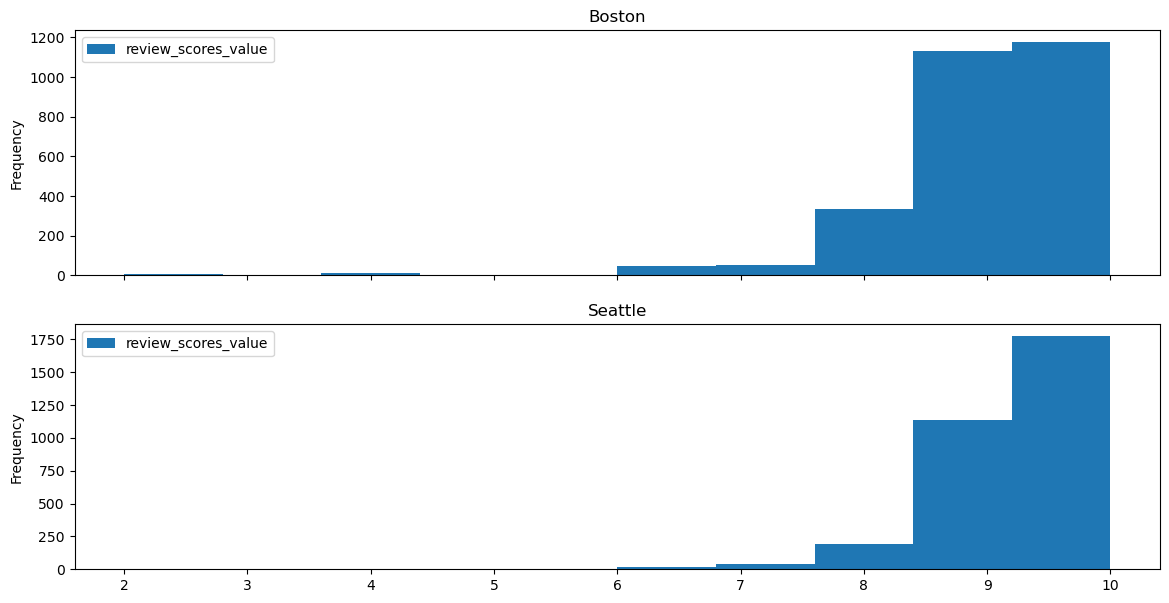

In [40]:
# Check if ratings could follow a normal distribution
df_listings.plot.hist(column = 'review_scores_value', by = 'city', figsize = (14, 7), sharex = True);

### The histograms don't indicate that the ratings are normally distributed. Thus we can not perform a t-test because one of the prerequisites is normal distribution. We have to use a Wilcoxon rank sum test instead with the hypotheses


\begin{align}
H_{0}: \mu_{0}\geq\mu_{1} \qquad vs. \qquad H_{1}: \mu_{0} < \mu_{1}
\end{align}

In [41]:
# We extract two series out of df_listings containing the review score values for Boston and Seattle respectively.
# We drop missing values
ratings_boston = df_listings.loc[df_listings.city == 'Boston' ,'review_scores_value'].dropna()
ratings_seattle = df_listings.loc[df_listings.city == 'Seattle' ,'review_scores_value'].dropna()

# We perform the Wilcoxon rank sum test and safe the value for the test statsitc and the p value
Stat, pvalue = ranksums(ratings_boston, ratings_seattle, alternative = 'less')
print("p-value:", pvalue)

p-value: 9.283213459080685e-28


### The p value is almost zero. That means we can reject the null hypothesis by significance level 5%. So the ratings of listings in Boston are significally lower than the ratings in Seattle. Or in other words: people in Seattle slightly rate listings better than people in Boston.

## What are the busiest times of the year to visit Boston and Seattle? By how much do prices spike?

### We know which location was available on which day. We use this information to compute a percentage of unavailability for each day in both cities. That helps us to make a statement about the busiest times of the year.

In [42]:
# Count available listings in Seattle per day
nonavailability = df_calendar.groupby(['city', 'date']).agg({'available': ['count', 'sum']})
nonavailability.columns = ['_'.join(col) for col in nonavailability.columns.values]
nonavailability = nonavailability.rename(columns = {'available_count': 'listings_cnt', 'available_sum': 'listings_available'})
nonavailability.loc[:, 'listings_not_available'] = nonavailability.listings_cnt - nonavailability.listings_available
nonavailability.loc[:, 'percentage_not_available'] = nonavailability.listings_not_available/nonavailability.listings_cnt
nonavailability = nonavailability.reset_index()
nonavailability.head()

,city,date,listings_cnt,listings_available,listings_not_available,percentage_not_available
0,Boston,2016-09-06,3586,570,3016,0.841049
1,Boston,2016-09-07,3586,932,2654,0.740100
2,Boston,2016-09-08,3586,999,2587,0.721417
3,Boston,2016-09-09,3586,981,2605,0.726436
4,Boston,2016-09-10,3586,956,2630,0.733408


### To get a better overview about the unavailability we plot the dates versus the unavailability rates.

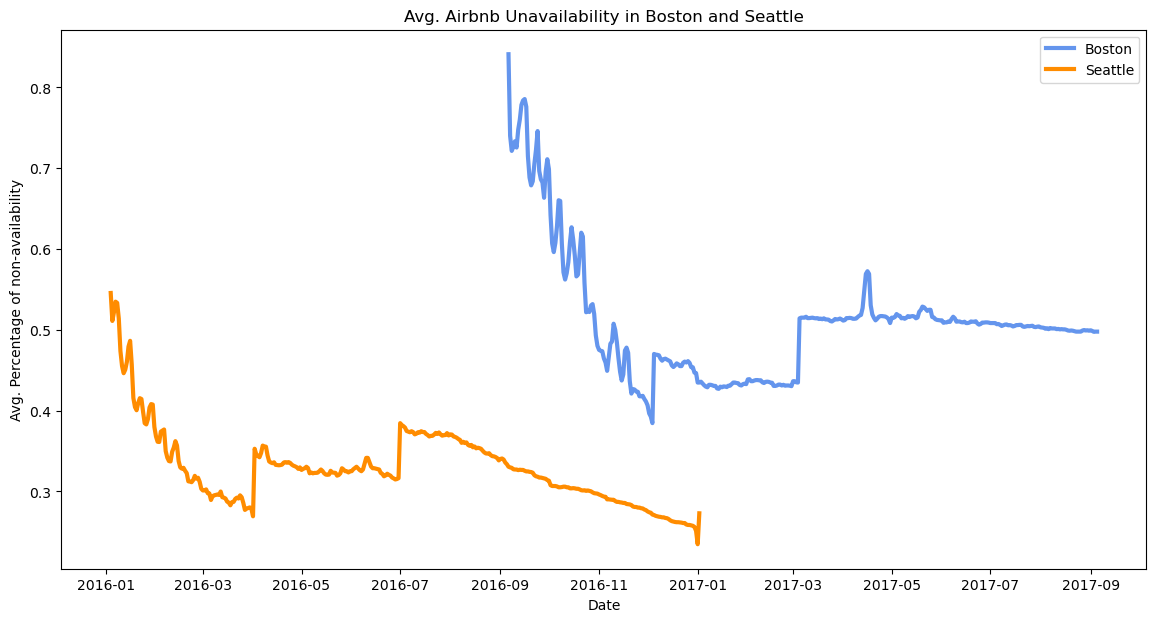

In [43]:
# plot of percentage of unavailability in Boston and Seattle
nonavailability.loc[nonavailability.city == 'Boston', 'color'] = 'Boston'
nonavailability.loc[nonavailability.city == 'Seattle', 'color'] = 'Seattle'
colors = {'Boston':'cornflowerblue', 'Seattle':'darkorange'}
fig, ax = plt.subplots(figsize=(14, 7))
grouped = nonavailability.groupby('color')
for key, group in grouped:
    group.plot(ax=ax, kind='line', x='date', y='percentage_not_available', label=key, color=colors[key], lw = 3, title = "Avg. Airbnb Unavailability in Boston and Seattle", xlabel = "Date", ylabel = "Avg. Percentage of non-availability")

### We can see that for both cities there is a radical decrease of unavailablility at the beginning. Even after some research I couln't really find the reason. Probably it was a change in law in the states of Massachusetts and Washington but not at the same time.

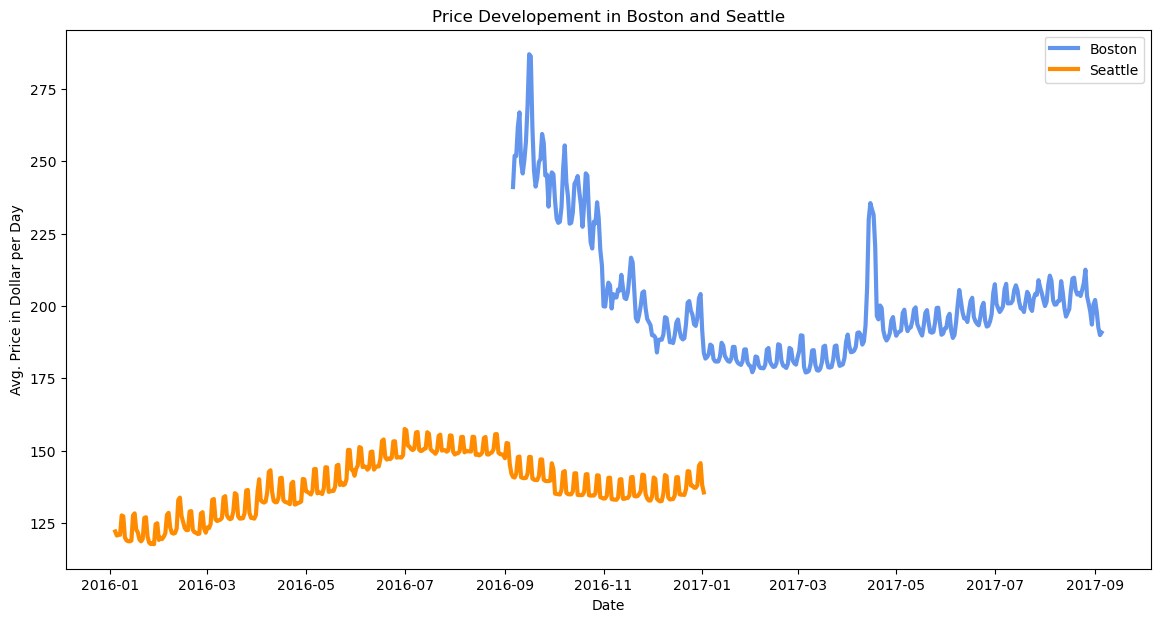

In [44]:
# What is the average price per day in Boston and Seattle?
avg_price = df_calendar.groupby(['city', 'date'])['price'].agg('mean')
avg_price = avg_price.reset_index()
avg_price.loc[avg_price.city == 'Boston', 'color'] = 'Boston'
avg_price.loc[avg_price.city == 'Seattle', 'color'] = 'Seattle'
colors = {'Boston':'cornflowerblue', 'Seattle':'darkorange'}
fig, ax = plt.subplots(figsize=(14, 7))
grouped = avg_price.groupby('color')
for key, group in grouped:
    group.plot(ax=ax, kind='line', x='date', y='price', label=key, color=colors[key], lw = 3, title = "Price Developement in Boston and Seattle", xlabel = "Date", ylabel = "Avg. Price in Dollar per Day")

### The Peak in April 2017 in the Boston price is interesting. 

In [45]:
# Find max price around April 2017 in Boston
pricepeak = avg_price.dropna().loc[(avg_price.city == 'Boston') & (avg_price.date.dt.month.isin([3,4,5])), ["date", "price"]]
pricepeak.loc[pricepeak.price == pricepeak.price.max(),]

,date,price
221,2017-04-15,235.501617


### The interesting peak is on April 15th. Looking that date up leads to the suggestion that it is about Boston Marathon, which always takes place at that time.
### Additionally prices seem to be generally higher during summer time. Also we can see that Boston has a higher price level than Seattle and also a bigger variance over the year. We can also see that prices even change during a week with higher prices on weekends.

In [47]:
# What is the price range for both cities?
price_range = avg_price.groupby('city').agg({'price': ['min', 'max']})
price_range[('price', 'range')] = price_range[('price', 'max')] - price_range[('price', 'min')]
price_range

price                        
                min         max       range
city                                       
Boston   177.022995  286.921967  109.898972
Seattle  117.685410  157.479996   39.794586